In [1]:
from PIL import Image
import re
import numpy as np
from IPython.display import display, Math, Latex

def crop_to_formula(image, padding = 30):
    # Image: 4 channel image with alpha.
    # Convert black pixels to white pixels.
    data = np.array(image)
    red, green, blue, alpha = data.T
    black_areas = (red < 10) & (blue < 10) & (green < 10)
    # Convert alpha to white.
    data[..., -1] = 255
    # Crop a box around the area that contains black pixels.
    coords = np.argwhere(black_areas)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    # Add padding.
    x0 = max(0, x0 - padding)
    y0 = max(0, y0 - padding)
    x1 = min(image.width, x1 + padding)
    y1 = min(image.height, y1 + padding)
    image = Image.fromarray(data[y0:y1, x0:x1])
    return image.convert('RGB')

def renderedLaTeXLabelstr2Formula(label: str):
    # We're matching \\label{...whatever} and removing it
    label = re.sub(r"\\label\{[^\}]*\}", "", label)
    # We match \, and remove it.
    label = re.sub(r"\\,", "", label)
    return label

def display_formula(latex: str):
    # Remove \mbox{...} - not supported by the inline MathJax renderer
    parsed_latex = re.sub(r"\\mbox\{[^\}]*\}", "", latex)
    display(Math(parsed_latex))

In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os, sys
sys.path.append(os.path.abspath('../'))

from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl
import torch as t

class renderedLaTeXDataset(Dataset):
    def __init__(self, image_folder, lst_file, formulas_file, processor, device, cutoff = None):
        self.image_folder = image_folder
        self.lst_file = lst_file
        self.formulas_file = formulas_file
        # self.train_filenames_df = pd.read_csv(self.lst_file, sep=" ", index_col = 0, header = None)
        self.train_filenames_df = pd.read_csv(self.lst_file)
        self.train_filenames_df=self.train_filenames_df.set_index('0')
        self.formulas = open(self.formulas_file, encoding = "ISO-8859-1", newline="\n").readlines()
        self.processor = processor
        self.device = device
        self.cutoff = cutoff if cutoff else len(self.train_filenames_df)
        if cutoff is not None:
            self.train_filenames_df = self.train_filenames_df.iloc[:self.cutoff]
            self.formulas = self.formulas[:self.cutoff]
        
    def __len__(self):
        return self.cutoff
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.train_filenames_df.iloc[idx, 0] + ".png")
        image = Image.open(img_name).convert('RGBA')
        image = crop_to_formula(image)
        inputs = self.processor(images = image,  padding = "max_length", return_tensors="pt").to(self.device)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        formula_idx = self.train_filenames_df.index[idx]
        caption = renderedLaTeXLabelstr2Formula(self.formulas[formula_idx])
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 512, truncation = True, # Tweak this
            ).to(self.device).squeeze()
        
        return inputs, caption
    
def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)

In [3]:
import os, sys
sys.path.append(os.path.abspath('../'))

def test_renderedLaTeXDataset(dataset, processor):
    
    iter_ = iter(dataset)
    inputs, captions = next(iter_)
    inputs_2, captions_2 = next(iter_)
    assert ''.join(processor.batch_decode(captions, skip_special_tokens=True)) != ''.join(processor.batch_decode(captions_2, skip_special_tokens=True)), "Passed dataset yields repeat captions."

    print("renderedLaTeXDataset tests passed.")

In [4]:
from torch.utils.data import Subset, random_split

In [5]:
import torch as t
import requests
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

device = t.device("cuda" if t.cuda.is_available() else "cpu")

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.transforms.v2
from sklearn.model_selection import train_test_split
import sklearn as skl
train_transforms = transforms.Compose([
    transforms.v2.RandomAffine(degrees = 5,
                               scale = (0.7, 1.1),
                               shear = 30),
    transforms.v2.ColorJitter(brightness = 0.2,
                              contrast = 0.2,
                              saturation = 0.2,
                              hue = 0.1)
])

# Hyperparams
NUM_EPOCHS = 2
LEARNING_RATE = 1e-5
BATCH_SIZE = 2 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_ds = renderedLaTeXDataset(image_folder = "/kaggle/input/formula-images/formula_images", 
                                lst_file = "/kaggle/input/custom/processed_im2latex_train.lst", 
                                formulas_file = "/kaggle/input/custom/im2latex_formulas.lst", 
                                device = device,
                                processor = processor
                                )
val_ds = renderedLaTeXDataset(image_folder = "/kaggle/input/formula-images/formula_images",
                                lst_file = "/kaggle/input/custom/processed_im2latex_val.lst",
                                formulas_file = "/kaggle/input/custom/im2latex_formulas.lst",
                                device = device,
                                processor = processor)
FRACTION = 0.3  # Use 10% of the dataset for training and validation

# Calculate subset size
train_size = int(len(train_ds) * FRACTION)
val_size = int(len(val_ds) * FRACTION)

# Randomly sample subsets
train_ds, _ = random_split(train_ds, [train_size, len(train_ds) - train_size])
val_ds, _ = random_split(val_ds, [val_size, len(val_ds) - val_size])

# DataLoaders with the subsets
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
# train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = SHUFFLE_DATASET, num_workers = 0)
# val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

test_renderedLaTeXDataset(train_ds, processor = processor)
test_renderedLaTeXDataset(val_ds, processor = processor)

print("Number of training samples:", len(train_ds))
print("Number of validation samples:", len(val_ds))

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()
pass
history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.95
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values = pixel_values,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)
# Save model
model.save_pretrained("../models/trocr-large-rendered-im2latex")
processor.save_pretrained("../models/trocr-large-rendered-im2latex")
#### 

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: [

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


renderedLaTeXDataset tests passed.


/tmp/ipykernel_24/2731746012.py:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = t.cuda.amp.GradScaler(enabled = True)


renderedLaTeXDataset tests passed.
Number of training samples: 25096
Number of validation samples: 2789


100%|██████████| 1395/1395 [13:34<00:00,  1.71it/s]


Validation loss: 0.11575349950395178


100%|██████████| 1395/1395 [13:18<00:00,  1.75it/s]


Validation loss: 0.08938141518195684


[]

In [6]:
model.save_pretrained("trocr-large-rendered-im2latex")
processor.save_pretrained("trocr-large-rendered-im2latex")

[]

In [7]:
val_filenames_df = pd.read_csv("/kaggle/input/custom/processed_im2latex_val.lst", 
                                names=["col0", "col1", "col2"],  # Specify names for the columns
                                index_col=False,  # Set to False as we are not using the first column as an index
                                header=None, 
                                sep=",")  # Use comma as the separator based on your data

# Now you can access the first column
first_column = val_filenames_df["col0"]  # Accessing the first column
print("First column values:\n", first_column)

# Proceed to sample a random row
random_row = val_filenames_df.sample(n=1)
random_idx = random_row.index[0]

# Load the corresponding formula image using the first column
formula_image_example = Image.open("/kaggle/input/formula-images/formula_images/" + val_filenames_df.loc[random_idx, "col1"] + ".png").convert('RGBA')


First column values:
 0           0
1           0
2       65546
3       38231
4          14
        ...  
9293    65524
9294    98293
9295    98294
9296    65531
9297    65534
Name: col0, Length: 9298, dtype: int64


Max length: 998


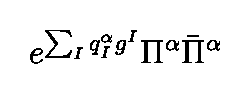

<IPython.core.display.Math object>

e^{\sum_Iq^\alpha_Ig^I}\Pi^\alpha\bar{\Pi}^\alpha



<IPython.core.display.Math object>

e\sum_{I} q_{I}^{\alpha} g^{I}\prod^{\alpha}\bar{\Gamma}^{\alpha}



In [8]:
formulas = open("/kaggle/input/custom/im2latex_formulas.lst", encoding="ISO-8859-1", newline="\n").readlines()

# # Print the number of formulas
# print("Number of training formulas: ", len(train_filenames_df))
# print("Number of validation formulas: ", len(val_filenames_df))

# Get maximum length of formulas
max_len = max([len(formula) for formula in formulas])
print("Max length:", max_len)

# Load model and processor
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/trocr-large-rendered-im2latex").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/working/trocr-large-rendered-im2latex")

# Sample a random row from the validation DataFrame
random_row = val_filenames_df.sample(n=1)
random_idx = random_row['col0'].values[0]  # Get the index of the sampled row
idx=random_row.index[0]
# idx=int(random_row['col0'].values[0])
# Load the corresponding formula image using the second column (col1)
formula_image_example = Image.open("/kaggle/input/formula-images/formula_images/" + val_filenames_df.loc[idx, "col1"] + ".png").convert('RGBA')

# Display cropped formula image
display(crop_to_formula(formula_image_example))

# Display formula
from IPython.display import display, Math, Latex
display_formula(renderedLaTeXLabelstr2Formula(formulas[random_idx]))
print(renderedLaTeXLabelstr2Formula(formulas[random_idx]))

# Generate model prediction
model_prediction = model.generate(processor(images=crop_to_formula(formula_image_example), return_tensors="pt").pixel_values.to(device), max_new_tokens=512)
str_pred = processor.batch_decode(model_prediction, skip_special_tokens=True)[0]
display_formula(str_pred)
print(str_pred)

/tmp/ipykernel_24/2774600456.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(int(idx))
/tmp/ipykernel_24/2774600456.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(idx)
/tmp/ipykernel_24/2774600456.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(formulas[int(idx)])


24160
4dbf1d6caa
\label{30}\Omega_3=\kappa\epsilon_{ij}\partial^i        \left(A^{(0)j}+\frac{1}{\sqrt{\kappa}}                \sum^{\infty}_{n=1}A^{(n)j} \right) \approx 0,



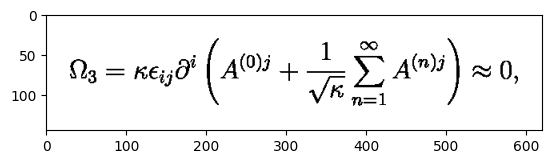

In [9]:
import matplotlib.pyplot as plt
i=val_filenames_df.sample(n=1)
idx=i['col0']
print(int(idx))
print(i['col1'].values[0])
name='/kaggle/input/formula-images/formula_images/'+ (i['col1'].values[0])+'.png'
int(idx)
image=Image.open(name).convert('RGBA')
plt.imshow(crop_to_formula(image))
print(formulas[int(idx)])

In [10]:
random_row = val_filenames_df.sample(n=1)
random_row.index[0]

1385

In [11]:
random_row

,col0,col1,col2
1385,4218,360e53de41,basic
